In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [38]:
def assignment(df, centroids, colmap):
    for i in centroids.keys():
        # distance 获取每个样本点到聚类中心的距离
        df['distance_from_{}'.format(i)] = (
            np.sqrt(
                (df['x'] - centroids[i][0]) ** 2 + (df['y'] - centroids[i][1]) ** 2
            )
        )
    # color
    distance_from_centroid_id = ['distance_from_{}'.format(i) for i in centroids.keys()]   # 获取每个样本点到聚类中心的距离的index
    df['closest'] = df.loc[:, distance_from_centroid_id].idxmin(axis = 1)  # 获取每个样本点到聚类中心的最小距离的index，添加 closest列
    df['closest'] = df['closest'].map(lambda x: int(x.lstrip('distance_from_')))  # 删掉closest列的元素名字中的distance_from_，保留数字
    df['color'] = df['closest'].map(lambda x: colmap[x])   # 添加 color列
    return df

In [39]:
def update(df, centroids):
    
    # recaculate the centroids
    # 把分配好的样本点在本类当中重新计算中心点
    for i in centroids.keys():
        centroids[i][0] = np.mean(df[df['closest'] == i]['x'])  
        centroids[i][1] = np.mean(df[df['closest'] == i]['y'])
    return centroids

In [58]:
def kpp_centers(df, colmap, k):
    '''
    1. take 1 center c1, chosen uniformly at random from X
    2. take a new center ci, choosing xi from X with probability D(xi)^2/(D(x1)^2+..+D(xi)^2+..+D(xn)^2)
    3. repeat step 2, until we have taken k centers altogether
    '''
    centroid_init_id = np.random.randint(len(df))
    centroids = {}
    centroids[0] = [df['x'][centroid_init_id], df['y'][centroid_init_id]]
    num_samples = len(df)
    for j in range(1, k + 1):
        total = 0.0
        
        # distance 获取每个样本点与聚类中心点的距离
        df['distance_from_{}'.format(j - 1)] = (
            np.sqrt((df['x'] - centroids[j - 1][0]) ** 2 + (df['y'] - centroids[j - 1][1]) ** 2)
        )
        
        # 获取每个样本点到聚类中心的距离的index
        distance_from_centroid_id = ['distance_from_{}'.format(j - 1) for i in centroids.keys()]  
        
        # 获取每个样本点到聚类中心的最小距离的index，添加 closest列
        df['closest'] = df.loc[:, distance_from_centroid_id].idxmin(axis = 1)   
        
        # 删掉closest列的元素名字中的distance_from_，保留数字
        df['closest'] = df['closest'].map(lambda x: int(x.lstrip('distance_from_')))
        
        # 每个样本最近的聚类中心距离求和
        for a in range(num_samples):
            total += df['distance_from_{}'.format(df['closest'][a])][a]
        total *= np.random.random()     # 取一个能落在total中的随机值
        
        # df['color'] 每次循环更新一次
        df['color'] = df['closest'].map(lambda x: colmap[x])
        
        # 用轮盘法选出下一个聚类中心， 让total依次减去每个样本的最近聚类中心距离，当total<0，此时的点为下一个聚类中心
        for i in range(num_samples):
            if j > 2:
                break 
            total -= df['distance_from_{}'.format(j - 1)][i]
            if total > 0:
                continue
            centroids[j] = [df['x'][i], df['y'][i]]
            break
        print(df)
    return df, centroids

In [59]:
def main():
    # 
    # 返回类似excel的二维矩阵
    df = pd.DataFrame({
        'x':[12, 20, 28, 18, 10, 29, 33, 24, 45, 45, 52, 51, 52, 55, 53, 55, 61, 64, 69, 72, 23],
        'y':[39, 36, 30, 52, 54, 20, 46, 55, 59, 63, 70, 66, 63, 58, 23, 14, 8, 19, 7, 24, 77]
    })
    
    k = 3
    
    colmap = {0: 'r', 1: 'g', 2: 'b'}
    
    # 初始化中心点，使用kmeans++方法
    df, centroids = kpp_centers(df, colmap, k)
    df = assignment(df, centroids, colmap)
    plt.scatter(df['x'], df['y'], color = df['color'], alpha = 0.5, edgecolor = 'k')
    for i in centroids.keys():
        plt.scatter(*centroids[i], color = colmap[i], linewidths = 6)
    plt.xlim(0, 80)
    plt.ylim(0, 80)
    plt.show()
    
    for i in range(10):
        plt.close()
        
        closest_centroids = df['closest'].copy(deep = True)
        centroids = update(df, centroids)
        
        plt.scatter(df['x'], df['y'], color = df['color'], alpha = 0.5, edgecolor = 'k')
        for i in centroids.keys():
            plt.scatter(*centroids[i], color = colmap[i], linewidths = 6)
        plt.xlim(0, 80)
        plt.ylim(0, 80)
        plt.show()
        
        df = assignment(df, centroids, colmap)
        
        if closest_centroids.equals(df['closest']):
            break

     x   y  distance_from_0  closest color
0   12  39        57.982756        0     r
1   20  36        49.648766        0     r
2   28  30        39.661064        0     r
3   18  52        61.522354        0     r
4   10  54        68.680419        0     r
5   29  20        34.176015        0     r
6   33  46        47.201695        0     r
7   24  55        59.816386        0     r
8   45  59        53.450912        0     r
9   45  63        57.280014        0     r
10  52  70        62.649820        0     r
11  51  66        58.855756        0     r
12  52  63        55.731499        0     r
13  55  58        50.358713        0     r
14  53  23        17.000000        0     r
15  55  14         8.485281        0     r
16  61   8         0.000000        0     r
17  64  19        11.401754        0     r
18  69   7         8.062258        0     r
19  72  24        19.416488        0     r
20  23  77        78.771822        0     r
     x   y  distance_from_0  closest color  distance_f

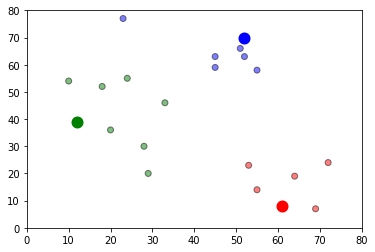

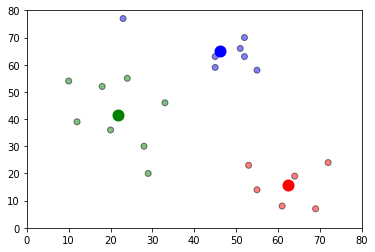

In [61]:
if __name__ == '__main__':
    main()